In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from embed_surv_utils import generate_survival_embedding_df

# Paths
DATA_PATH = "/data/gusev/USERS/jpconnor/clinical_text_project/data/"
SURV_PATH = os.path.join(DATA_PATH, 'survival_data/')
NOTES_PATH = os.path.join(DATA_PATH, "batched_datasets/VTE_data/processed_datasets/")
TREATMENT_PRED_PATH = os.path.join(DATA_PATH,'treatment_prediction/first_line_treatment_prediction_data/')
buffer_path = os.path.join(TREATMENT_PRED_PATH, 'buffered_prediction_data/')

# Load treatment data
treatment_df = (pd.read_csv("/data/gusev/USERS/mjsaleh/profile_lines_of_rx/profile_rxlines.csv")
                .rename(columns={"MRN": "DFCI_MRN", "LOT_start_date": "treatment_start_date"}))
treatment_df["treatment_start_date"] = pd.to_datetime(treatment_df["treatment_start_date"])
treatment_df = treatment_df.sort_values(["DFCI_MRN", "treatment_start_date"])
treatment_df["treatment_line"] = treatment_df.groupby("DFCI_MRN").cumcount() + 1
treatments = (treatment_df["Treatment_type"]
              .str.replace(";", "", regex=False)
              .str.split().explode())
dummies = pd.get_dummies(treatments, prefix="PX_on", drop_first=True).groupby(level=0).max()
treatment_df = pd.concat([treatment_df, dummies], axis=1)

notes_meta = pd.read_csv(os.path.join(NOTES_PATH, 'full_VTE_embeddings_metadata.csv'))
embeddings_data = np.load(os.path.join(NOTES_PATH, 'full_VTE_embeddings_as_array.npy'))

note_types = ['Clinician', 'Imaging', 'Pathology']
pool_fx = {nt: 'time_decay_mean' for nt in note_types}

In [34]:
# treatment_classification_df = treatment_df.loc[treatment_df['treatment_line'] == 1, ['DFCI_MRN', 'treatment_start_date'] + [col for col in treatment_df.columns if 'PX_' in col]]
# buffers = [0, 30, 60, 90]

# notes_meta_sub = (notes_meta[notes_meta['DFCI_MRN'].isin(treatment_classification_df['DFCI_MRN'])]
#                   .merge(treatment_classification_df, on='DFCI_MRN', how='left')
#                   .assign(NOTE_TIME_REL_PRED_START_DT = lambda df: (
#                       pd.to_datetime(df['NOTE_DATETIME']) - pd.to_datetime(df['treatment_start_date'])).dt.days))

# for buffer in buffers:
#     treatment_prediction_embedding_vals = generate_survival_embedding_df(notes_meta=notes_meta_sub, survival_df=None, embedding_array=embeddings_data, 
#                                                                          note_types=note_types, note_timing_col="NOTE_TIME_REL_PRED_START_DT", 
#                                                                          max_note_window=-buffer, pool_fx=pool_fx, decay_param=0.01, continuous_window=False)

#     full_treatment_prediction_dataset = treatment_classification_df.merge(treatment_prediction_embedding_vals.dropna(), on='DFCI_MRN')

#     full_treatment_prediction_dataset.to_csv(os.path.join(buffer_path, f'first_line_prediction_df_w_{buffer}_day_buffer.csv'), index=False) 

In [25]:
import os
import numpy as np
import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm

TREATMENT_PROPENSITY_PATH = os.path.join(DATA_PATH, 'treatment_prediction/first_line_propensity/')
buffer_path = os.path.join(TREATMENT_PRED_PATH, 'buffered_prediction_data/')

col_names = {'model_preds': [f'pred_label_{col}' for col in target_cols],
             'model_probs': [f'prob_{col}' for col in target_cols],
             'ground_truth': [f'ground_truth_{col}' for col in target_cols]}

result_dfs = []
for buffer in [0, 30, 60, 90]:
    
    pred_df = pd.read_csv(os.path.join(buffer_path, f'first_line_prediction_df_w_{buffer}_day_buffer.csv'))
    
    target_cols = ['PX_on_ICI', 'PX_on_IO', 'PX_on_cellular', 'PX_on_chemo', 'PX_on_hormonal', 'PX_on_targetted']
    pred_cols = [col for col in pred_df.columns if ('IMAGING' in col) or ('PATHOLOGY' in col) or ('CLINICIAN' in col)]
    
    X = pred_df[['DFCI_MRN'] + pred_cols]
    Y = pred_df[target_cols].astype(int)

    pred_cols = [col for col in X.columns if col != 'DFCI_MRN']

    # 5-fold stratified CV
    mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

    cv_mrns = []
    cv_preds = []
    cv_probs = []
    cv_true = []

    for fold, (train_idx, test_idx) in enumerate(mskf.split(X, Y), 1):

        # Split
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

        cv_mrns += X_test['DFCI_MRN'].tolist()

        X_train = X_train.drop(columns=['DFCI_MRN'])
        X_test = X_test.drop(columns=['DFCI_MRN'])

        # Scale
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        # Fit model
        clf = OneVsRestClassifier(LogisticRegression(max_iter=1000, solver="lbfgs"))
        clf.fit(X_train, Y_train.values)

        # Predict
        Y_pred = clf.predict(X_test)
        Y_prob = clf.predict_proba(X_test)

        cv_preds += Y_pred.tolist()
        cv_probs += Y_prob.tolist()
        cv_true += Y_test.values.tolist()
        
    # Save predictions with probabilities
    out_df = pd.DataFrame({
        'DFCI_MRN': cv_mrns,
        'model_preds': cv_preds,
        'model_probs': cv_probs,
        'ground_truth': cv_true})

    # Unpack each list column into new columns
    expanded = []
    for col, names in col_names.items():
        expanded.append(pd.DataFrame(out_df[col].tolist(), columns=names))
    
    # Concatenate back together
    df_expanded = pd.concat(expanded, axis=1)
    
    # Combine with other non-list columns (if any)
    df_final = pd.concat([out_df.drop(columns=list(col_names)), df_expanded], axis=1)
    
    out_file = os.path.join(TREATMENT_PROPENSITY_PATH, f'first_line_propensity_w_{buffer}_buffer.csv')
    df_final.to_csv(out_file, index=False)

In [32]:
target_cols

['PX_on_ICI',
 'PX_on_IO',
 'PX_on_cellular',
 'PX_on_chemo',
 'PX_on_hormonal',
 'PX_on_targetted']

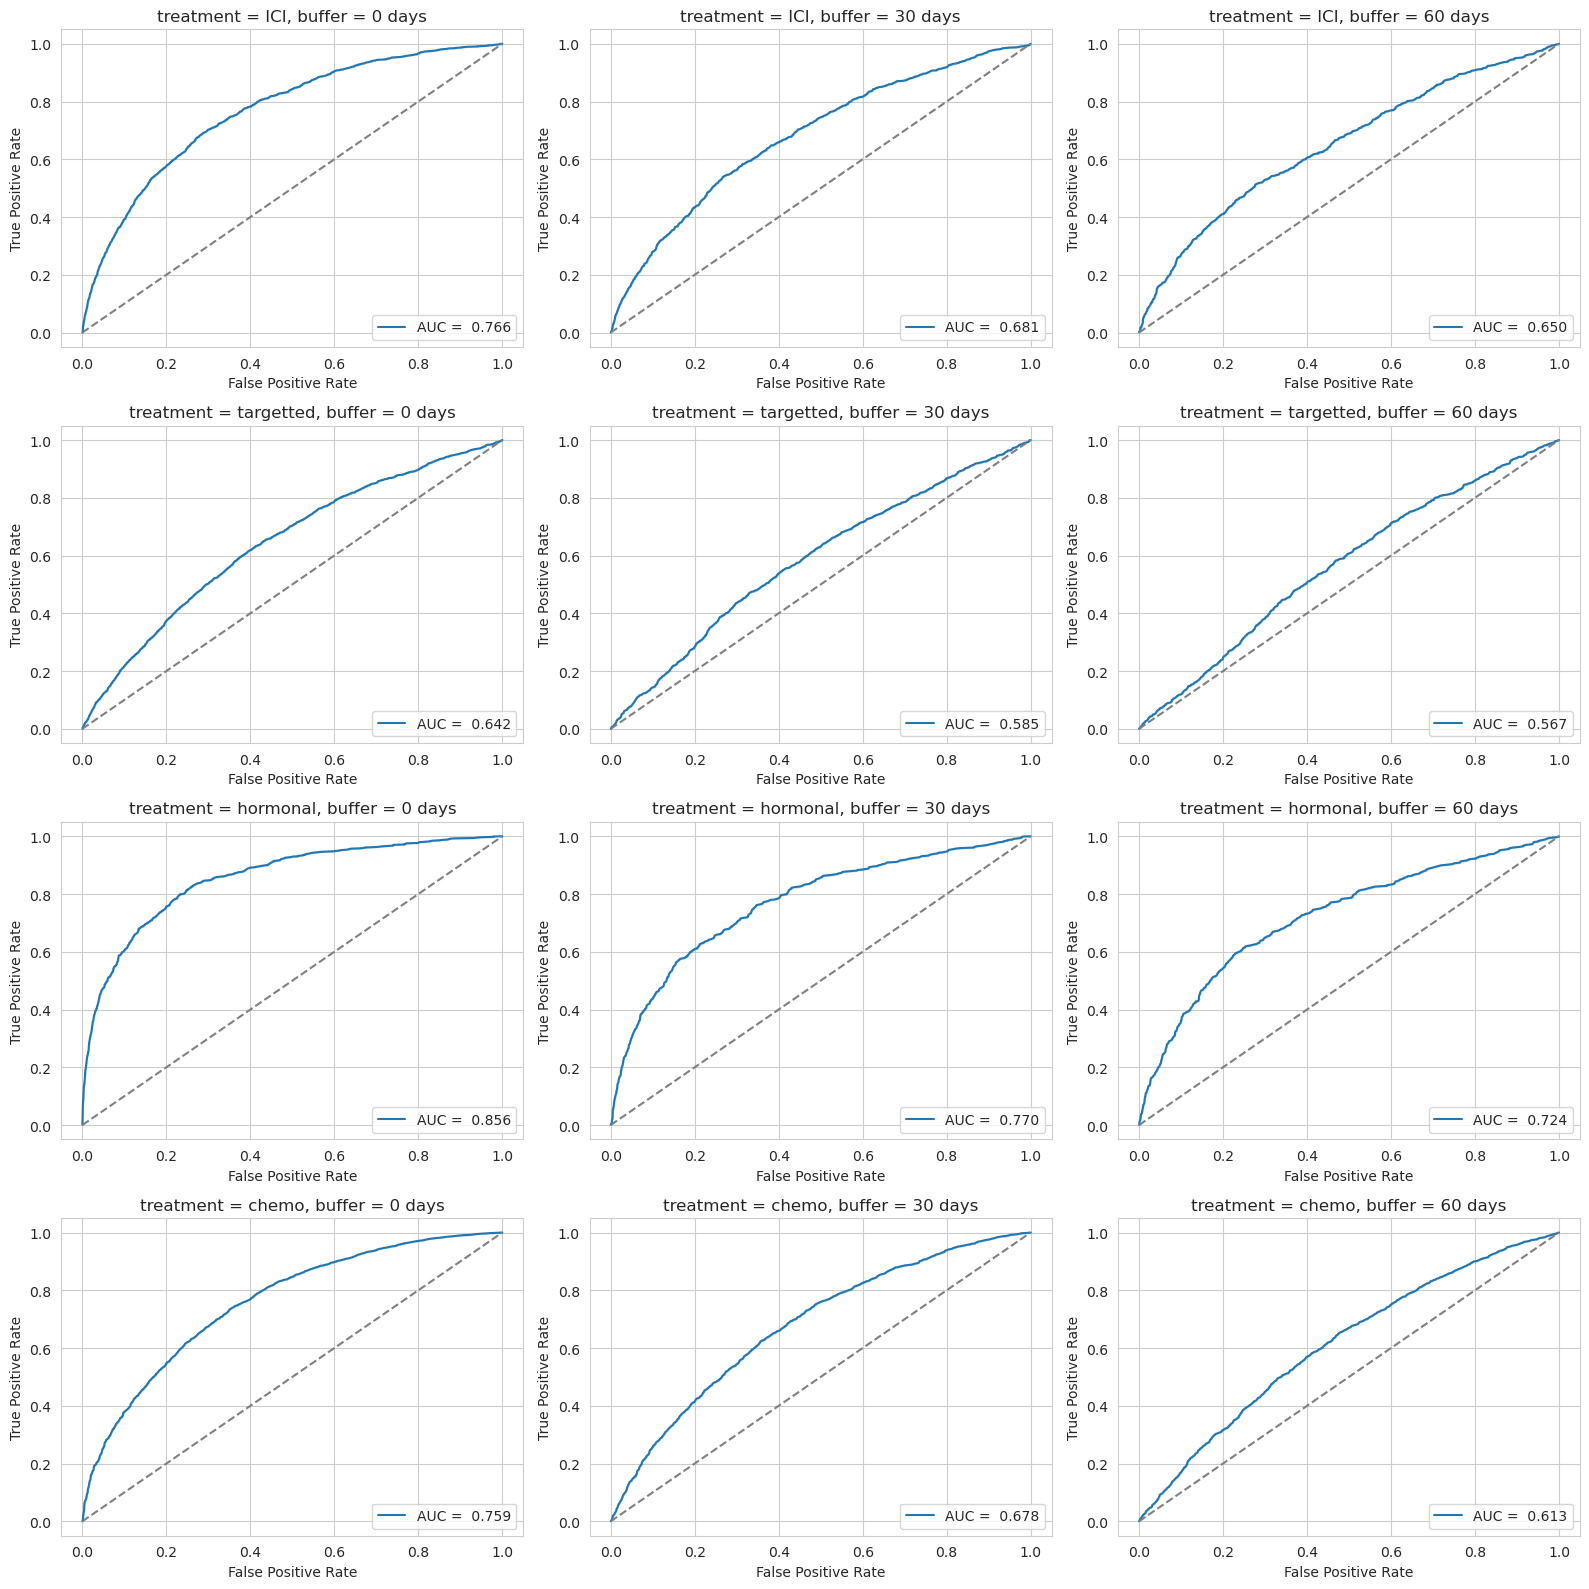

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve

sns.set_style("whitegrid")
eval_cols = ['PX_on_ICI', 'PX_on_targetted', 'PX_on_hormonal', 'PX_on_chemo']

buffers = [0, 30, 60]
fig, axes = plt.subplots(len(eval_cols), len(buffers), figsize=(16,16))

for y, buffer in enumerate(buffers):
    for x, target in enumerate(eval_cols):
        
        pred_df = pd.read_csv(os.path.join(TREATMENT_PROPENSITY_PATH, f'first_line_propensity_w_{buffer}_buffer.csv'))
        
        auc = roc_auc_score(pred_df[f'ground_truth_{target}'], pred_df[f'prob_{target}'])
        fpr, tpr, thresholds = roc_curve(pred_df[f'ground_truth_{target}'], pred_df[f'prob_{target}'])
        
        ax = axes[x, y]
        sns.lineplot(x=fpr, y=tpr, ax=ax, label=f'AUC = {auc : 0.3f}')
        sns.lineplot(x=[0,1], y=[0,1], ax=ax, linestyle='--', color='gray')
        
        ax.set_title(f'treatment = {target.replace('PX_on_', '')}, buffer = {buffer} days')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right')
        
plt.tight_layout()
plt.savefig("/data/gusev/USERS/jpconnor/clinical_text_project/figures/bar_cindex_per_treatment.png", dpi=300, bbox_inches="tight")

plt.show()